# Dataset Generation - Extended with 6 Stations (A-F)

In [1]:
import random
import numpy as np
import json

DATASET_SIZE = 1
OUTPUT_FILE = "demonstrations_with_states_extended.txt"

# Feature Definitions: track location (A,B,C,D,E,F) and cut status
# A: Station with all utensils and ingredients at start
# B: Cutting station
# C: Stove
# D: Plating
# E: Serving
# F: Washing

ITEMS = ["pot", "pan", "plate", "tomato", "meat", "onion", "mushroom", "lettuce", "egg"]
CUTTABLES = ["tomato", "onion", "mushroom", "lettuce"]
LOCATIONS = ["A", "B", "C", "D", "E", "F"]

class StateTracker:
    def __init__(self):
        self.feature_map = {}
        idx = 0
        self.num = 20
        
        # Location features: e.g., "pot_A": 0, "pot_B": 1... (9 items × 6 locations = 54 features)
        for item in ITEMS:
            for loc in LOCATIONS:
                self.feature_map[f"{item}_{loc}"] = idx
                idx += 1
        
        # Cut status features: e.g., "tomato_cut": 54... (4 cuttables = 4 features)
        for item in CUTTABLES:
            self.feature_map[f"{item}_cut"] = idx
            idx += 1
        
        # Washing status features: track if items have been washed (9 items = 9 features)
        for item in ITEMS:
            self.feature_map[f"{item}_washed"] = idx
            idx += 1
        
        # Global status features
        self.feature_map["stove_on"] = idx
        idx += 1
        self.feature_map["plate_served"] = idx  # Track if plate has been served
        
        self.n_features = idx + 1
        self.reset()
        print("Feature_map: ", self.feature_map)
        print(f"Total features: {self.n_features}")
    
    def reset(self):
        """Reset state to initial conditions (everything at A, raw, unwashed, stove off)"""
        self.current_state = np.zeros(self.n_features, dtype=int)
        for item in ITEMS: self.set_feature(f"{item}_A", 1)
    
    def set_feature(self, key, value):
        if key in self.feature_map: self.current_state[self.feature_map[key]] = value
    
    def get_feature(self, key):
        return self.current_state[self.feature_map[key]] if key in self.feature_map else 0
    
    def get_state_vector(self):
        if self.num:
            # print(self.current_state)
            self.num -= 1
        return self.current_state.copy()
    
    def apply_action(self, action_str):
        """Parse action string and update internal state vector"""
        if action_str.startswith("move"):
            # Parse "move (item origin to dest)"
            content = action_str[action_str.find("(")+1 : action_str.find(")")]
            item, origin, _, dest = content.split()
            self.set_feature(f"{item}_{origin}", 0)
            self.set_feature(f"{item}_{dest}", 1)
        elif action_str.startswith("cut"):
            # Parse "cut (item loc)"
            content = action_str[action_str.find("(")+1 : action_str.find(")")]
            item = content.split()[0]
            self.set_feature(f"{item}_cut", 1)
        elif action_str.startswith("turn_on"):  self.set_feature("stove_on", 1)
        elif action_str.startswith("turn_off"): self.set_feature("stove_on", 0)
        elif action_str.startswith("serve"):    self.set_feature("plate_served", 1) # Parse "serve (plate E)"
        elif action_str.startswith("wash"):
            # Parse "wash (item F)"
            content = action_str[action_str.find("(")+1 : action_str.find(")")]
            item = content.split()[0]
            self.set_feature(f"{item}_washed", 1)
        

class RecipeGenerator:
    def __init__(self):
        self.demos = []
        self.tracker = StateTracker()
    
    def _record_trajectory(self, actions):
        """Run actions through state tracker and record (state, action) pairs"""
        self.tracker.reset()
        trajectory = []
        for action in actions:
            state_vector = self.tracker.get_state_vector().tolist()
            trajectory.append({"state": state_vector, "action": action})
            self.tracker.apply_action(action)
        
        final_state_vector = self.tracker.get_state_vector().tolist()
        trajectory.append({"state": final_state_vector, "action": "stop"})
        self.demos.append(trajectory)
    
    # Recipe Definitions - Extended with serving and washing steps
    
    def generate_grilled_steak(self):       return ["move (pan A to C)", "move (meat A to C)", "turn_on (stove C)", "move (plate A to B)", "turn_off (stove C)", "move (meat C to B)", "move (plate B to D)", "move (plate D to E)", "serve (plate E)", "move (pan C to F)", "wash (pan F)"]
    def generate_salad(self):               return ["move (lettuce A to B)", "cut (lettuce B)", "move (onion A to B)", "cut (onion B)", "move (plate A to B)", "move (plate B to D)", "move (plate D to E)", "serve (plate E)", "move (plate E to F)", "wash (plate F)"]
    def generate_burger(self):              return ["move (pan A to C)", "move (meat A to C)", "turn_on (stove C)", "move (lettuce A to B)", "cut (lettuce B)", "turn_off (stove C)", "move (meat C to B)", "move (plate A to B)", "move (plate B to D)", "move (plate D to E)", "serve (plate E)", "move (pan C to F)", "wash (pan F)", "move (plate E to F)", "wash (plate F)"]
    def generate_boiled_eggs(self):         return ["move (pot A to C)", "move (egg A to C)", "turn_on (stove C)", "turn_off (stove C)", "move (plate A to C)", "move (plate C to D)", "move (plate D to E)", "serve (plate E)", "move (pot C to F)", "wash (pot F)"]
    
    def generate_tomato_soup(self):         return ["move (pot A to C)", "move (tomato A to B)", "cut (tomato B)", "move (tomato B to C)", "turn_on (stove C)", "move (plate A to D)", "move (pot C to D)", "move (plate D to E)", "serve (plate E)", "move (pot D to F)", "wash (pot F)"]
    def generate_mushroom_soup(self):       return ["move (pot A to C)", "move (mushroom A to B)", "cut (mushroom B)", "move (mushroom B to C)", "move (onion A to B)", "cut (onion B)", "move (onion B to C)", "turn_on (stove C)", "move (plate A to D)", "move (pot C to D)", "move (plate D to E)", "serve (plate E)", "move (pot D to F)", "wash (pot F)", "move (plate E to F)", "wash (plate F)"]
    def generate_tomato_onion_soup_1(self): return ["move (pot A to C)", "move (tomato A to B)", "cut (tomato B)", "move (tomato B to C)", "move (onion A to B)", "cut (onion B)", "move (onion B to C)", "turn_on (stove C)", "move (plate A to D)", "move (pot C to D)", "move (plate D to E)", "serve (plate E)", "move (pot D to F)", "wash (pot F)"]    
    def generate_tomato_onion_soup_2(self): return ["move (pot A to C)", "move (onion A to B)", "cut (onion B)", "move (onion B to C)", "move (tomato A to B)", "cut (tomato B)", "move (tomato B to C)", "turn_on (stove C)", "move (plate A to D)", "move (pot C to D)", "move (plate D to E)", "serve (plate E)", "move (pot D to F)", "wash (pot F)", "move (plate E to F)", "wash (plate F)"]
    
    def generate_random_dataset(self, count):
        # available_recipes = [self.generate_tomato_soup, self.generate_grilled_steak, self.generate_mushroom_stew, self.generate_salad, self.generate_burger, self.generate_boiled_eggs]
        available_recipes = [self.generate_tomato_onion_soup_1]
        print(f"Generating {count} state-aware demonstrations...")
        for i in range(count):
            recipe_func = random.choice(available_recipes)
            actions = recipe_func()
            self._record_trajectory(actions)
    
    # def save_to_file(self):
    #     # Save as JSON Lines (each line is a full trajectory object)
    #     with open(OUTPUT_FILE, "w") as f:
    #         for demo in self.demos:
    #             f.write(json.dumps(demo) + "\n")
    #     print(f"Done! Saved {len(self.demos)} trajectories to {OUTPUT_FILE}")
    #     print(f"State Vector Size: {self.tracker.n_features}")

# if __name__ == "__main__":
#     gen = RecipeGenerator()
#     gen.generate_random_dataset(DATASET_SIZE)
#     gen.save_to_file()

# IRL

In [ ]:
import numpy as np
import json

def load_demonstrations(filepath):
    """Load demonstrations from JSON file"""
    with open(filepath, 'r') as f:
        demo_lists = [json.loads(line) for line in f.read().strip().split('\n')]
    
    demonstrations = []
    all_actions = set()
    
    for demo in demo_lists:
        trajectory = [(tuple(step['state']), step['action']) for step in demo]
        demonstrations.append(trajectory)
        all_actions.update(step['action'] for step in demo)
    
    return demonstrations, sorted(list(all_actions))

def create_state_action_mappings(demonstrations, unique_actions):
    """Create bidirectional mappings between states/actions and indices"""
    # Collect unique states
    unique_states = set()
    for trajectory in demonstrations:
        unique_states.update(state for state, _ in trajectory)
    
    # Create mappings
    state_to_idx = {state: idx for idx, state in enumerate(sorted(unique_states))}
    idx_to_state = {idx: state for state, idx in state_to_idx.items()}
    action_to_idx = {action: idx for idx, action in enumerate(unique_actions)}
    idx_to_action = {idx: action for action, idx in action_to_idx.items()}
    
    print("state_to_idx:", state_to_idx)
    print("idx_to_state:", idx_to_state)
    print("action_to_idx:", action_to_idx)
    print("idx_to_action:", idx_to_action)
    
    return state_to_idx, idx_to_state, action_to_idx, idx_to_action

def create_feature_matrix(idx_to_state):
    """
    Create task-discriminative features for extended kitchen environment.
    State vector layout (72 dims):
    - Indices 0-53: Object locations (9 objects × 6 locations)
    - Indices 54-57: Cut status (tomato, onion, mushroom, lettuce)
    - Indices 58-66: Washing status (9 items)
    - Index 67: Stove on/off
    - Index 68: Plate served
    """
    features = []
    
    for idx in range(len(idx_to_state)):
        state = np.array(idx_to_state[idx])
        feat = []
        # Features 0-5: Items at each location (A through F)
        # For each location, count how many items are present
        for loc_idx in range(6):  # 6 locations (A, B, C, D, E, F)
            item_indices = [loc_idx + i*6 for i in range(9)]  # Every 6th index for this location
            feat.append(np.sum(state[item_indices]))
        # Features 6-11: Specific items at critical locations
        feat.append(state[0*6 + 2])  # pot_C is at index 2 (pot is item 0, C is location 2)         # pot at C (cooking station)
        feat.append(state[1*6 + 2])  # pan at C
        feat.append(state[2*6 + 3])  # plate at D (plating)
        feat.append(state[2*6 + 4])  # plate at E (serving)
        feat.append(state[2*6 + 5])  # plate at F (washing)
        feat.append(state[0*6 + 5] + state[1*6 + 5])  # pot_F + pan_F                               # Any cooking vessel (pot or pan) at F (for washing)
        feat.extend(state[54:58])  # Cut status features                                            # Cut status of vegetables
        # Features 16-17: Vegetables at cutting station    
        veg_at_B = sum([state[3*6 + 1], state[5*6 + 1], state[6*6 + 1], state[7*6 + 1]])  # tomato, onion, mushroom, lettuce at B  
        feat.append(veg_at_B)
        # Cut vegetables at cooking station
        cut_veg_at_C = sum([state[54]*state[3*6 + 2], state[55]*state[5*6 + 2], state[56]*state[6*6 + 2], state[57]*state[7*6 + 2]])
        feat.append(cut_veg_at_C)
        # Features 18-19: Stove usage
        feat.append(state[67])  # Stove on/off
        items_at_stove = sum([state[i*6 + 2] for i in range(9)])  # All items at C
        feat.append(state[67] * items_at_stove)  # Stove on with items
        # Features 20-28: Washing status for all items
        feat.extend(state[58:67])  # Washing status features
        # Features 29-30: Washing-related compound features
        items_at_F = sum([state[i*6 + 5] for i in range(9)])  # Items at washing station (F)
        feat.append(items_at_F)
        # Washed items count
        washed_count = sum(state[58:67])
        feat.append(washed_count)
        # Feature 31: Serving status
        feat.append(state[68])  # Plate served
        # Feature 32: Plate at serving station with serving status
        feat.append(state[2*6 + 4] * state[68])  # plate_E * plate_served
        # Features 33-34: Task completion indicators
        cooking_complete = (state[0*6 + 3] + state[1*6 + 3])  # pot or pan at D                     # Cooking complete (items moved from stove)
        feat.append(cooking_complete)
        # Full workflow (served and washed)
        workflow_complete = state[68] * (washed_count > 0)
        feat.append(workflow_complete)
        
        features.append(feat)
    
    feature_matrix = np.array(features)
    print(f"Feature matrix shape: {feature_matrix.shape}")
    print(f"Feature value ranges - min: {feature_matrix.min(axis=0)}, max: {feature_matrix.max(axis=0)}")
    
    return feature_matrix

def max_ent_irl(demonstrations, feature_matrix, state_to_idx, action_to_idx, 
                n_iterations=100, learning_rate=0.05, temperature=2.0, gamma=0.9):
    """
    Maximum Entropy IRL with improved convergence.
    
    Returns:
        reward_weights: Learned feature weights
        recovered_rewards: State rewards (feature_matrix @ reward_weights)
    """
    n_states = feature_matrix.shape[0]
    n_features = feature_matrix.shape[1]
    n_actions = len(action_to_idx)
    
    print(f"\n=== Starting MaxEnt IRL ===")
    print(f"States: {n_states}, Actions: {n_actions}, Features: {n_features}")
    
    # Initialize reward weights
    reward_weights = np.random.randn(n_features) * 0.1
    
    # Compute empirical feature expectations from demonstrations
    empirical_feature_expectations = np.zeros(n_features)
    state_action_pairs = set()
    transition_model = {}
    
    for trajectory in demonstrations:
        traj_features = np.zeros(n_features)
        for i, (state, action) in enumerate(trajectory):
            s_idx = state_to_idx[state]
            traj_features += (gamma ** i) * feature_matrix[s_idx]
        empirical_feature_expectations += traj_features
    empirical_feature_expectations /= len(demonstrations)
    
    # Build state-action pairs and transition model
    for trajectory in demonstrations:
        for i in range(len(trajectory)):
            state, action = trajectory[i]
            s_idx, a_idx = state_to_idx[state], action_to_idx[action]
            state_action_pairs.add((s_idx, a_idx))
            if i < len(trajectory) - 1:         transition_model[(s_idx, a_idx)] = state_to_idx[trajectory[i + 1][0]]
    
    print(f"\nFound {len(state_action_pairs)} unique (state, action) pairs")
    print(f"Empirical feature expectation norm: {np.linalg.norm(empirical_feature_expectations):.4f}")
    
    # Gradient descent with adaptive learning rate
    best_diff = float('inf')
    patience = 0
    best_weights = reward_weights.copy()
    momentum = np.zeros(n_features)
    momentum_beta = 0.9
    
    for iteration in range(n_iterations):
        current_lr = learning_rate * (0.95 ** (patience // 5))
        rewards = feature_matrix @ reward_weights
        
        # Backward value iteration
        q_values = {}  # (s_idx, a_idx) -> Q-value
        values = rewards.copy()
        
        for _ in range(30):
            new_values = rewards.copy()
            
            # Update Q-values
            for (s_idx, a_idx) in state_action_pairs:
                if (s_idx, a_idx) in transition_model:      q_values[(s_idx, a_idx)] = rewards[s_idx] + gamma * values[transition_model[(s_idx, a_idx)]]
                else:                                       q_values[(s_idx, a_idx)] = rewards[s_idx]  # Terminal action
            
            # Update values using soft-max
            for s_idx in range(n_states):
                available_qs = [q_values[(s_idx, a_idx)] for a_idx in range(n_actions) if (s_idx, a_idx) in q_values]
                if available_qs:
                    available_qs = np.array(available_qs)
                    max_q = np.max(available_qs)
                    new_values[s_idx] = max_q + temperature * np.log(np.sum(np.exp((available_qs - max_q) / temperature)))
            
            if np.max(np.abs(new_values - values)) < 1e-6:  break
            values = new_values
        
        # Compute soft policy from Q-values
        policy = {}
        for s_idx in range(n_states):
            state_qs = [(a_idx, q_values[(s_idx, a_idx)]) for a_idx in range(n_actions) if (s_idx, a_idx) in q_values]
            if state_qs:
                state_actions, state_q_vals = zip(*state_qs)
                state_q_vals = np.array(state_q_vals)
                max_q = np.max(state_q_vals)
                probs = np.exp((state_q_vals - max_q) / temperature)
                probs /= np.sum(probs)
                for a_idx, prob in zip(state_actions, probs):   policy[(s_idx, a_idx)] = prob
        
        # Monte Carlo estimation of expected feature counts
        expected_feature_counts = np.zeros(n_features)
        for _ in range(100):  # Sample 100 trajectories
            s_idx = state_to_idx[demonstrations[np.random.randint(len(demonstrations))][0][0]]
            traj_features = np.zeros(n_features)
            
            for t in range(20):  # Max trajectory length
                traj_features += (gamma ** t) * feature_matrix[s_idx]
                
                # Sample action according to policy
                available = [(a_idx, policy[(s_idx, a_idx)]) for a_idx in range(n_actions) if (s_idx, a_idx) in policy]
                if not available:       break
                
                actions, probs = zip(*available)
                probs = np.array(probs) / np.sum(probs)
                a_idx = np.random.choice(actions, p=probs)
                
                if (s_idx, a_idx) not in transition_model:      break
                s_idx = transition_model[(s_idx, a_idx)]
            
            expected_feature_counts += traj_features
        expected_feature_counts /= 100
        
        # Gradient update with momentum
        gradient = empirical_feature_expectations - expected_feature_counts
        gradient -= 0.01 * reward_weights  # L2 regularization
        grad_norm = np.linalg.norm(gradient)
        
        momentum = momentum_beta * momentum + (1 - momentum_beta) * gradient
        reward_weights += current_lr * momentum
        
        # Track best solution
        if grad_norm < best_diff:
            best_diff = grad_norm
            best_weights = reward_weights.copy()
            patience = 0
        else:       patience += 1
        
        if iteration % 10 == 0:
            print(f"Iteration {iteration}: Gradient norm = {grad_norm:.6f}, "
                  f"Reward range = [{np.min(reward_weights):.2f}, {np.max(reward_weights):.2f}], "
                  f"Best = {best_diff:.6f}, LR = {current_lr:.4f}")
        
        if grad_norm < 0.01 or patience > 20:
            print(f"Converged at iteration {iteration}")
            break
    
    print(f"\nFinal best gradient norm: {best_diff:.6f}")
    recovered_rewards = feature_matrix @ best_weights
    return best_weights, recovered_rewards

def predict_action(state, reward_weights, feature_matrix, state_to_idx, action_to_idx, idx_to_action, transition_model, temperature=2.0, gamma=0.9):
    """Predict most likely action from a given state"""
    if state not in state_to_idx:
        print(f"Warning: State not seen during training")
        return None, {}
    
    s_idx = state_to_idx[state]
    rewards = feature_matrix @ reward_weights
    
    # Compute Q-values for all valid actions
    valid_actions = []
    q_values_list = []
    
    for a_idx in range(len(action_to_idx)):
        if (s_idx, a_idx) in transition_model:
            s_next_idx = transition_model[(s_idx, a_idx)]
            q_value = rewards[s_idx] + gamma * rewards[s_next_idx]
            valid_actions.append(a_idx)
            q_values_list.append(q_value)
    
    if not valid_actions:
        print(f"Warning: No valid actions from this state!")
        return None, {}
    
    # Compute softmax policy
    q_values_array = np.array(q_values_list)
    max_q = np.max(q_values_array)
    action_probs_array = np.exp((q_values_array - max_q) / temperature)
    action_probs_array /= np.sum(action_probs_array)
    
    # Create action probability dictionary
    action_probs = {idx_to_action[a_idx]: prob for a_idx, prob in zip(valid_actions, action_probs_array)}
    
    # Return most likely action
    best_action_idx = valid_actions[np.argmax(action_probs_array)]
    return idx_to_action[best_action_idx], action_probs

# Testing

In [3]:
# Generate training demonstrations
gen = RecipeGenerator()
gen.generate_random_dataset(1)

# Convert to format expected by IRL
train_demonstrations = []
all_actions_set = set()

for demo in gen.demos:
    trajectory = [(tuple(step['state']), step['action']) for step in demo]
    train_demonstrations.append(trajectory)
    all_actions_set.update(step['action'] for step in demo)

unique_actions = sorted(list(all_actions_set))

print(f"\n=== Training Data ===")
print(f"Number of demonstrations: {len(train_demonstrations)}")
print(f"Unique actions: {len(unique_actions)}")
print(f"Actions: {unique_actions}")

# Create mappings
state_to_idx, idx_to_state, action_to_idx, idx_to_action = create_state_action_mappings(
    train_demonstrations, unique_actions
)

# Create feature matrix
feature_matrix = create_feature_matrix(idx_to_state)

# Run IRL
reward_weights, recovered_rewards = max_ent_irl(
    train_demonstrations, 
    feature_matrix, 
    state_to_idx, 
    action_to_idx,
    n_iterations=100,
    learning_rate=0.05
)

print(f"\n=== Learned Reward Weights ===")
print(f"Shape: {reward_weights.shape}")
print(f"Top 5 positive weights: {np.sort(reward_weights)[-5:][::-1]}")
print(f"Top 5 negative weights: {np.sort(reward_weights)[:5]}")

Feature_map:  {'pot_A': 0, 'pot_B': 1, 'pot_C': 2, 'pot_D': 3, 'pot_E': 4, 'pot_F': 5, 'pan_A': 6, 'pan_B': 7, 'pan_C': 8, 'pan_D': 9, 'pan_E': 10, 'pan_F': 11, 'plate_A': 12, 'plate_B': 13, 'plate_C': 14, 'plate_D': 15, 'plate_E': 16, 'plate_F': 17, 'tomato_A': 18, 'tomato_B': 19, 'tomato_C': 20, 'tomato_D': 21, 'tomato_E': 22, 'tomato_F': 23, 'meat_A': 24, 'meat_B': 25, 'meat_C': 26, 'meat_D': 27, 'meat_E': 28, 'meat_F': 29, 'onion_A': 30, 'onion_B': 31, 'onion_C': 32, 'onion_D': 33, 'onion_E': 34, 'onion_F': 35, 'mushroom_A': 36, 'mushroom_B': 37, 'mushroom_C': 38, 'mushroom_D': 39, 'mushroom_E': 40, 'mushroom_F': 41, 'lettuce_A': 42, 'lettuce_B': 43, 'lettuce_C': 44, 'lettuce_D': 45, 'lettuce_E': 46, 'lettuce_F': 47, 'egg_A': 48, 'egg_B': 49, 'egg_C': 50, 'egg_D': 51, 'egg_E': 52, 'egg_F': 53, 'tomato_cut': 54, 'onion_cut': 55, 'mushroom_cut': 56, 'lettuce_cut': 57, 'pot_washed': 58, 'pan_washed': 59, 'plate_washed': 60, 'tomato_washed': 61, 'meat_washed': 62, 'onion_washed': 63, '

In [4]:
# Build transition model for prediction
transition_model = {}
for trajectory in train_demonstrations:
    for i in range(len(trajectory) - 1):
        state, action = trajectory[i]
        next_state = trajectory[i + 1][0]
        s_idx = state_to_idx[state]
        a_idx = action_to_idx[action]
        transition_model[(s_idx, a_idx)] = state_to_idx[next_state]

# Test prediction on the training recipe
print("\n=== Testing on Training Recipe ===")
test_trajectory = train_demonstrations[0]

correct = 0
total = len(test_trajectory) - 1  # Exclude terminal state

for i, (state, true_action) in enumerate(test_trajectory[:-1]):
    predicted_action, action_probs = predict_action(
        state, reward_weights, feature_matrix, 
        state_to_idx, action_to_idx, idx_to_action, transition_model
    )
    
    is_correct = (predicted_action == true_action)
    if is_correct:
        correct += 1
    
    print(f"Step {i+1}:")
    print(f"  True action: {true_action}")
    print(f"  Predicted: {predicted_action} {'✓' if is_correct else '✗'}")
    print(f"  Confidence: {action_probs.get(predicted_action, 0):.2%}")
    if not is_correct and true_action in action_probs:
        print(f"  True action probability: {action_probs[true_action]:.2%}")

accuracy = correct / total if total > 0 else 0
print(f"\nAccuracy: {correct}/{total} = {accuracy:.1%}")


=== Testing on Training Recipe ===
Step 1:
  True action: move (pot A to C)
  Predicted: move (pot A to C) ✓
  Confidence: 100.00%
Step 2:
  True action: move (tomato A to B)
  Predicted: move (tomato A to B) ✓
  Confidence: 100.00%
Step 3:
  True action: cut (tomato B)
  Predicted: cut (tomato B) ✓
  Confidence: 100.00%
Step 4:
  True action: move (tomato B to C)
  Predicted: move (tomato B to C) ✓
  Confidence: 100.00%
Step 5:
  True action: move (onion A to B)
  Predicted: move (onion A to B) ✓
  Confidence: 100.00%
Step 6:
  True action: cut (onion B)
  Predicted: cut (onion B) ✓
  Confidence: 100.00%
Step 7:
  True action: move (onion B to C)
  Predicted: move (onion B to C) ✓
  Confidence: 100.00%
Step 8:
  True action: turn_on (stove C)
  Predicted: turn_on (stove C) ✓
  Confidence: 100.00%
Step 9:
  True action: move (plate A to D)
  Predicted: move (plate A to D) ✓
  Confidence: 100.00%
Step 10:
  True action: move (pot C to D)
  Predicted: move (pot C to D) ✓
  Confidence: 1

# Test on new recipe

In [5]:
def test_on_new_recipe(recipe_func, recipe_name, reward_weights, feature_matrix, 
                       state_to_idx, action_to_idx, idx_to_action, transition_model,
                       add_to_training=False, train_demonstrations=None):
    """
    Test the learned model on a new recipe.
    
    Args:
        recipe_func: Function that generates the recipe action sequence
        recipe_name: Name of the recipe for display
        ... (other IRL model parameters)
        add_to_training: If True, add this recipe to training set
        train_demonstrations: List to add demonstration to if add_to_training=True
    """
    print(f"\n{'='*60}")
    print(f"Testing on: {recipe_name}")
    print(f"{'='*60}")
    
    # Generate test recipe
    test_gen = RecipeGenerator()
    actions = recipe_func()
    test_gen._record_trajectory(actions)
    
    # Convert to trajectory format
    test_trajectory = [(tuple(step['state']), step['action']) for step in test_gen.demos[0]]
    
    # Test prediction
    correct = 0
    total = len(test_trajectory) - 1
    unknown_states = 0
    
    for i, (state, true_action) in enumerate(test_trajectory[:-1]):
        if state not in state_to_idx:
            unknown_states += 1
            print(f"Step {i+1}: State not in training set ✗")
            continue
        predicted_action, action_probs = predict_action(state, reward_weights, feature_matrix, state_to_idx, action_to_idx, idx_to_action, transition_model)
        is_correct = (predicted_action == true_action)
        if is_correct: correct += 1 
        print(f"Step {i+1}:")
        print(f"  True: {true_action}")
        print(f"  Pred: {predicted_action} {'✓' if is_correct else '✗'}")
        print(f"  Conf: {action_probs.get(predicted_action, 0):.2%}")
    
    accuracy = correct / total if total > 0 else 0
    print(f"\nResults:")
    print(f"  Correct: {correct}/{total}")
    print(f"  Accuracy: {accuracy:.1%}")
    print(f"  Unknown states: {unknown_states}")
    
    # Add to training set if requested
    if add_to_training and train_demonstrations is not None:
        train_demonstrations.append(test_trajectory)
        print(f"\n✓ Added {recipe_name} to training set")
        print(f"  New training set size: {len(train_demonstrations)}")
    
    return accuracy, unknown_states

# Adaptive IRL

In [6]:
def adaptive_irl_loop(initial_recipe, test_recipes, n_test_iterations=3):
    """
    Adaptive IRL: Start with one recipe, test on new ones, and iteratively improve.
    
    Args:
        initial_recipe: Function that generates initial training recipe
        test_recipes: List of (recipe_func, recipe_name) tuples for testing
        n_test_iterations: How many times to test each recipe
    """
    print("\n" + "="*80)
    print("ADAPTIVE IRL EXPERIMENT")
    print("="*80)
    
    # Initial training
    print("\n[PHASE 1] Initial Training")
    print("-" * 80)
    gen = RecipeGenerator()
    gen.generate_random_dataset(1)
    
    train_demonstrations = []
    all_actions_set = set()
    
    for demo in gen.demos:
        trajectory = [(tuple(step['state']), step['action']) for step in demo]
        train_demonstrations.append(trajectory)
        all_actions_set.update(step['action'] for step in demo)
    
    test_history = []
    
    # Testing loop
    for test_num in range(1, n_test_iterations + 1):
        print(f"\n[PHASE {test_num + 1}] Test Iteration {test_num}")
        print("-" * 80)
        print(f"Current training set size: {len(train_demonstrations)} demonstrations")
        
        # Rebuild mappings and retrain with current data
        unique_actions = sorted(list(all_actions_set))
        state_to_idx, idx_to_state, action_to_idx, idx_to_action = create_state_action_mappings(train_demonstrations, unique_actions)
        feature_matrix = create_feature_matrix(idx_to_state)
        
        reward_weights, recovered_rewards = max_ent_irl(train_demonstrations, feature_matrix, state_to_idx, action_to_idx, n_iterations=100, learning_rate=0.05)
        
        # Build transition model
        transition_model = {}
        for trajectory in train_demonstrations:
            for i in range(len(trajectory) - 1):
                state, action = trajectory[i]
                next_state = trajectory[i + 1][0]
                s_idx = state_to_idx[state]
                a_idx = action_to_idx[action]
                transition_model[(s_idx, a_idx)] = state_to_idx[next_state]
        
        # Test on each new recipe
        for recipe_func, recipe_name in test_recipes:
            # Test without adding to training
            accuracy, unknown_states = test_on_new_recipe(  recipe_func,    recipe_name,    reward_weights,     feature_matrix,     state_to_idx,   action_to_idx,  idx_to_action,  transition_model,   add_to_training=False)
            # Record results
            test_history.append({   'test_num': test_num,   'recipe': recipe_name,      'accuracy': accuracy,   'unknown_states': unknown_states,   'training_size_before': len(train_demonstrations)})
            # Add to training set for next iteration
            test_gen = RecipeGenerator()
            actions = recipe_func()
            test_gen._record_trajectory(actions)
            new_trajectory = [(tuple(step['state']), step['action']) for step in test_gen.demos[0]]
            train_demonstrations.append(new_trajectory)
            all_actions_set.update(step['action'] for step in test_gen.demos[0])
    
    # Summary
    print("\n" + "="*80)
    print("EXPERIMENT SUMMARY")
    print("="*80)
    print(f"\nFinal training set size: {len(train_demonstrations)} demonstrations")
    print(f"Total unique actions: {len(all_actions_set)}")
    print(f"\nAccuracy progression:")
    for record in test_history:
        print(f"  Test {record['test_num']} - {record['recipe']}: {record['accuracy']:.1%} "
              f"({record['unknown_states']} unknown states)")
    
    return test_history, train_demonstrations

# Run adaptive IRL experiment
test_recipes = [(gen.generate_tomato_onion_soup_2, "Tomato Onion Soup (Recipe 2)"), (gen.generate_tomato_soup, "Tomato Soup"), (gen.generate_mushroom_soup, "Mushroom Soup")]

test_history, final_train_set = adaptive_irl_loop(
    gen.generate_tomato_onion_soup_1,
    test_recipes,
    n_test_iterations=3
)


ADAPTIVE IRL EXPERIMENT

[PHASE 1] Initial Training
--------------------------------------------------------------------------------
Feature_map:  {'pot_A': 0, 'pot_B': 1, 'pot_C': 2, 'pot_D': 3, 'pot_E': 4, 'pot_F': 5, 'pan_A': 6, 'pan_B': 7, 'pan_C': 8, 'pan_D': 9, 'pan_E': 10, 'pan_F': 11, 'plate_A': 12, 'plate_B': 13, 'plate_C': 14, 'plate_D': 15, 'plate_E': 16, 'plate_F': 17, 'tomato_A': 18, 'tomato_B': 19, 'tomato_C': 20, 'tomato_D': 21, 'tomato_E': 22, 'tomato_F': 23, 'meat_A': 24, 'meat_B': 25, 'meat_C': 26, 'meat_D': 27, 'meat_E': 28, 'meat_F': 29, 'onion_A': 30, 'onion_B': 31, 'onion_C': 32, 'onion_D': 33, 'onion_E': 34, 'onion_F': 35, 'mushroom_A': 36, 'mushroom_B': 37, 'mushroom_C': 38, 'mushroom_D': 39, 'mushroom_E': 40, 'mushroom_F': 41, 'lettuce_A': 42, 'lettuce_B': 43, 'lettuce_C': 44, 'lettuce_D': 45, 'lettuce_E': 46, 'lettuce_F': 47, 'egg_A': 48, 'egg_B': 49, 'egg_C': 50, 'egg_D': 51, 'egg_E': 52, 'egg_F': 53, 'tomato_cut': 54, 'onion_cut': 55, 'mushroom_cut': 56, 'l

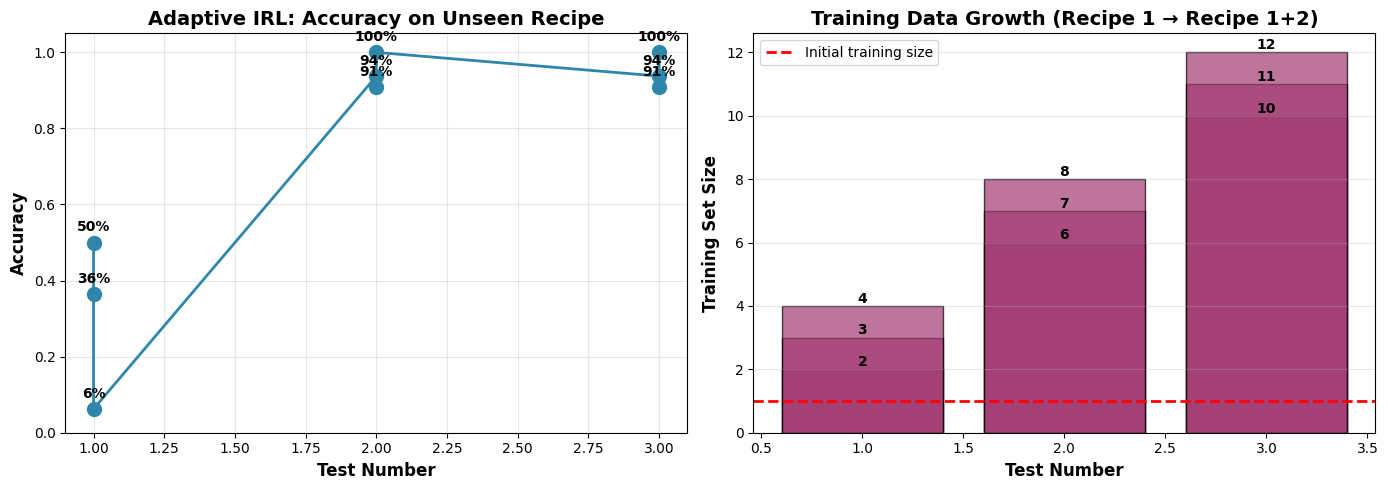


Visualization complete!


In [ ]:
# Optional: Visualize learning progress
import matplotlib.pyplot as plt

if test_history:
    test_nums = [r['test_num'] for r in test_history]
    accuracies = [r['accuracy'] for r in test_history]
    train_sizes = [r['training_size_before'] + r['test_num'] for r in test_history]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Accuracy over tests
    ax1.plot(test_nums, accuracies, marker='o', linewidth=2, markersize=10, color='#2E86AB')
    ax1.set_xlabel('Test Number', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title('Adaptive IRL: Accuracy on Unseen Recipe', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.05)
    for x, y in zip(test_nums, accuracies): ax1.text(x, y + 0.03, f'{y:.0%}', ha='center', fontsize=10, fontweight='bold')
    
    # Plot 2: Training set growth
    ax2.bar(test_nums, train_sizes, color='#A23B72', alpha=0.7, edgecolor='black')
    ax2.axhline(y=len(train_demonstrations), color='red', linestyle='--', label='Initial training size', linewidth=2)
    ax2.set_xlabel('Test Number', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Training Set Size', fontsize=12, fontweight='bold')
    ax2.set_title('Training Data Growth (Recipe 1 → Recipe 1+2)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend()
    for x, y in zip(test_nums, train_sizes):
        ax2.text(x, y + 0.1, f'{y}', ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualization complete!")